# Text-to-speech by fine-tuning SpeechT5 on the Harper Valley Bank dataset

In this section, we fine-tune the SpeechT5 model from Hugging Face Transformers on the Harper Valley Bank dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

path = 'NLP-Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/NLP-Project'

## Install required packages


In [3]:
!pip install datasets soundfile speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [4]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.6 MB/s eta 0:00:00


## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again on the Harper Valley Bank dataset.

In [5]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

#The processor contains the tokenizer and the feature extractor
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Load the dataset

We load the dataset from HuggingFace. The dataset is a subset of the original dataset and the audio are divided in each utterance, which will make the prediction more effective

In [6]:
from datasets import load_dataset, Audio

train_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="train"
)
validation_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="validation"
)
test_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="test"
)

Generating train split:   0%|          | 0/11344 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1690 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6121 [00:00<?, ? examples/s]

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [7]:
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16000))
validation_dataset = validation_dataset.cast_column("audio", Audio(sampling_rate=16000))
test_dataset = test_dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's quickly check how many examples are in each split.

In [8]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(11344, 1690, 6121)

Let's build a container of all the splits

In [9]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict()
dataset['train'] = train_dataset
dataset['validation'] = validation_dataset
dataset['test'] = test_dataset

Looking at some examples



In [10]:
for i in range(10):
  print(dataset['train'][i])

{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_1669_4339.wav', 'array': array([0., 0., 0., ..., 0., 0., 0.]), 'sampling_rate': 16000}, 'speaker_id': '46', 'text': 'hello this is harper valley national bank', 'utt_index': 1, 'channel': 2, 'role': 'agent', 'start_ms': 1669, 'duration_ms': 2670, 'intent': 'replace card', 'dialog_acts': ['statement_open']}
{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_4839_5979.wav', 'array': array([ 4.76074219e-03,  4.63867188e-03,  2.38037109e-03, ...,
       -3.05175781e-05, -3.05175781e-05,  0.00000000e+00]), 'sampling_rate': 16000}, 'speaker_id': '46', 'text': 'my name is elizabeth', 'utt_index': 2, 'channel': 2, 'role': 'agent', 'start_ms': 4839, 'duration_ms': 1140, 'intent': 'replace card', 'dialog_acts': ['statement_open']}
{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_6469_7699.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -3.05175781e-05,  

## Speakers

We compute how many speakers are present in the training dataset and the number of examples for each of them

In [11]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["train"]["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

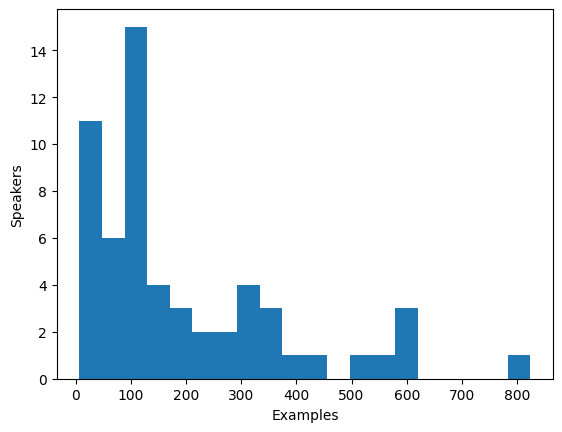

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [13]:
import torch
from speechbrain.inference.classifiers import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [14]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [16]:
processed_example = prepare_dataset(dataset["train"][0])

This returns:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [17]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [18]:
tokenizer = processor.tokenizer
tokenizer.decode(processed_example["input_ids"])

'hello this is harper valley national bank</s>'

Speaker embeddings should be a 512-element vector:

In [19]:
processed_example["speaker_embeddings"].shape

(512,)

The labels are a log-mel spectrogram with 80 mel bins.

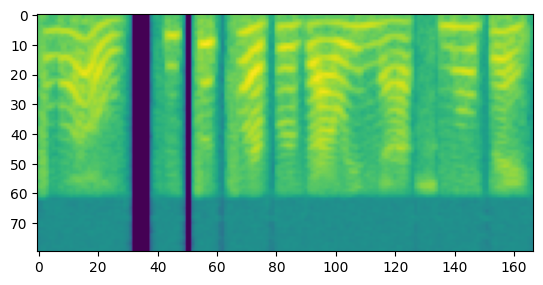

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [21]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [22]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [23]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

We can now process the entire dataset

In [26]:
dataset["train"] = dataset["train"].map(
    prepare_dataset, remove_columns=dataset["train"].column_names,
)
dataset["validation"] = dataset["validation"].map(
    prepare_dataset, remove_columns=dataset["validation"].column_names,
)
dataset["test"] = dataset["test"].map(
    prepare_dataset, remove_columns=dataset["test"].column_names,
)

Map:   0%|          | 0/11344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1690 [00:00<?, ? examples/s]

Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

If some of the examples in the dataset are longer than the maximum input length the model can handle (600 tokens), we remove those from the dataset. In fact, to allow for larger batch sizes we remove anything over 200 tokens.

In [27]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/11344 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1690 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6121 [00:00<?, ? examples/s]

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [28]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [29]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [30]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [31]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 43]),
 'attention_mask': torch.Size([3, 43]),
 'labels': torch.Size([3, 166, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speech-to-text",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
)

Create the trainer object using the model, dataset, and data collator.

In [33]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

max_steps is given, it will override any value given in num_train_epochs


We start the training process

In [34]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.568900,0.487907
2000,0.509100,0.466962
3000,0.493600,0.458254
4000,0.483200,0.455390


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=4000, training_loss=0.5573906059265137, metrics={'train_runtime': 5038.659, 'train_samples_per_second': 25.404, 'train_steps_per_second': 0.794, 'total_flos': 8911156041854352.0, 'train_loss': 0.5573906059265137, 'epoch': 11.283497884344147})

We save the model for later use

In [35]:
model.save_pretrained('/speech-to-text_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}


## Evaluate

Let's load and use the model to synthesize some speech!


In [36]:
model = SpeechT5ForTextToSpeech.from_pretrained("/speech-to-text_model")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [37]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [38]:
text = "hello, my name is John. I would like to schedule an appointment "

In [39]:
tokenizer.decode(tokenizer(text)["input_ids"])

'hello, my name is John. I would like to schedule an appointment</s>'

In [40]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [41]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

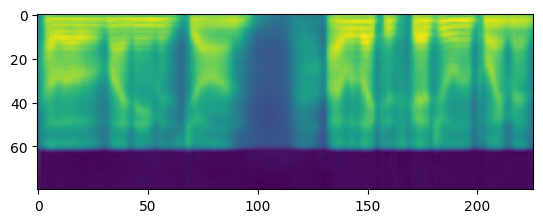

In [42]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [43]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [44]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [45]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)